In [213]:
# -------
# IMPORT LIBRAIRIES
# -------
import numpy as np
import pandas as pd
import plotly.express as px
from python_module.pricing_model import SABRModel
from python_module.tools import maximize_with_bounds

pd.options.display.max_rows = 999
pd.options.display.max_columns = 999
pd.options.display.float_format = '{:,.2f}'.format

In [214]:
# -------
# INPUTS
# -------

# Pricing parameters
F     = 5000
alpha = 0.15
beta  = 1.0
rho   = -0.2
nu    = 1.5
r     = 0
atm_bd = 5
tail_bd = 5

# Scenario parameters
scenario_min = -0.3
scenario_max = 0.3
scenario_step = 0.05

option_strikes = [0.1, 0]

target_gamma = 10_000_000

In [215]:
# Scenario parameters
num = int((scenario_max-scenario_min)/0.01 + 1)
slide_to_compute = list(np.round(np.linspace(start=scenario_min, stop=scenario_max, num=num), 2))

# Option portfolio
market_data_list = list()
for strike in option_strikes:
    K = F * (1+strike)
    T = tail_bd / 250
    option_type = 'call' if K >= F else 'put'
    market_pricing_results = SABRModel.compute_option(F, K, T, alpha, beta, rho, nu, r, option_type, slide_list=slide_to_compute)
    market_data_list.append({
        'symbol': f"{tail_bd}T_{K}K_{option_type}",
        'option_type': option_type, 
        'time_to_maturity': tail_bd, 
        'F':F, 'r': r, 'K': K, 'T': T, 'K/F': (K/F) - 1 ,**market_pricing_results})

market_data_df = pd.DataFrame(market_data_list)
market_data_df = market_data_df.set_index('symbol')
market_data_df = market_data_df.drop(0, axis=1)
market_data_df[0] = market_data_df['theta']

# Compute target quantity
market_data_df['gamma_cash'] = (market_data_df['gamma']*(F**2)) / 100
atm_symbol = market_data_df[market_data_df['K']==F].index[0]
qty = target_gamma / market_data_df.loc[atm_symbol, 'gamma_cash']
weights = (market_data_df.loc[atm_symbol, 'theta'] / market_data_df['theta']) * qty
weights[atm_symbol] *= -1
weights *= -1

In [216]:
market_data_df

,option_type,time_to_maturity,F,r,K,T,K/F,IV,price,delta,gamma,vega,theta,vanna,volga,-0.30,-0.29,-0.28,-0.27,-0.26,-0.25,-0.24,-0.23,-0.22,-0.21,-0.20,-0.19,-0.18,-0.17,-0.16,-0.15,-0.14,-0.13,-0.12,-0.11,-0.10,-0.09,-0.08,-0.07,-0.06,-0.05,-0.04,-0.03,-0.02,-0.01,0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09,0.10,0.11,0.12,0.13,0.14,0.15,0.16,0.17,0.18,0.19,0.20,0.21,0.22,0.23,0.24,0.25,0.26,0.27,0.28,0.29,0.30,0,gamma_cash
symbol,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
5T_5500.0K_call,call,5,5000,0,"5,500.00",0.02,0.10,0.16,0.00,0.00,0.00,0.00,-0.00,0.00,3.63,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.01,0.06,0.24,0.84,2.65,7.39,17.91,37.36,67.32,106.61,152.05,200.51,250.10,300.01,349.99,399.99,449.99,499.99,549.99,599.99,649.99,699.99,749.99,799.99,849.99,899.99,949.99,999.98,-0.00,0.10
5T_5000K_call,call,5,5000,0,"5,000.00",0.02,0.00,0.15,42.45,0.50,0.00,2.82,-4.25,0.03,-0.21,713.91,688.70,663.49,638.28,613.07,587.85,562.64,537.43,512.22,487.00,461.79,436.58,411.37,386.16,360.94,335.73,310.52,285.31,260.09,234.88,209.67,184.46,159.26,134.08,108.98,84.14,59.97,37.46,18.34,5.06,4.25,16.94,35.69,57.95,81.84,106.36,131.08,155.85,180.64,205.42,230.21,255.00,279.79,304.58,329.36,354.15,378.94,403.73,428.51,453.30,478.09,502.88,527.66,552.45,577.24,602.03,626.82,651.60,676.39,701.18,-4.25,937.17


In [217]:
weights

symbol
5T_5500.0K_call   -91,991,753.52
5T_5000K_call          10,670.42
Name: theta, dtype: float64

In [218]:
market_data_df['vega']*weights

symbol
5T_5500.0K_call   -28,760.52
5T_5000K_call      30,099.00
dtype: float64

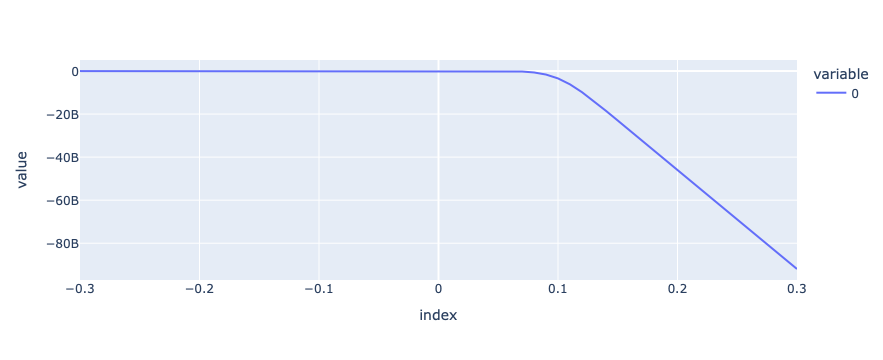

In [219]:
px.line(market_data_df.loc[:, slide_to_compute].multiply(weights, axis=0).sum(axis=0).sort_index())

In [220]:
market_data_df.loc[:, ['vega', 'theta', 'gamma_cash']].multiply(weights, axis=0).sum(axis=0)

vega           1,338.48
theta              0.00
gamma_cash   869,607.81
dtype: float64